## Loading packages

In [1]:
# this is for the jupyter notebook at JupyterLab
# to make sys.path between the terminal and Jupyter same
import sys

print(sys.path) # especially the path to site-packages are different... so thats why couldn't find correct package...

# remove weird paths...
sys.path = sys.path[:4]+[sys.path[6]]
print(sys.path)

['/nfs/team205/kk18/notebooks/P48_Foetal-heart_Visium/notebooks/notebooks_for_manuscript', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python39.zip', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/lib-dynload', '', '/nfs/users/nfs_k/kk18/.local/lib/python3.9/site-packages', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages']
['/nfs/team205/kk18/notebooks/P48_Foetal-heart_Visium/notebooks/notebooks_for_manuscript', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python39.zip', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/lib-dynload', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages']


In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import seaborn as sns

from cell2location.plt import plot_spatial

import os

/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The i

In [3]:
import session_info
session_info.show()

In [4]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [5]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots'

## Function

In [6]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

## Read in adata

In [7]:
adata_vis = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-FFPE_foetal_raw.h5ad')

# add abundance to .obs
df = adata_vis.obsm['q05_cell_abundance_w_sf'].copy()
## rename columns
df.columns = [x.replace('q05cell_abundance_w_sf_','') for x in df.columns]
adata_vis.obs[df.columns]=df.copy()

# set symboßl as var_names
adata_vis.var.set_index('SYMBOL',inplace=True)

adata_vis

AnnData object with n_obs × n_vars = 19973 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'JC_edit', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts', 'CoronaryVesselAdventitialFibroblasts', 'MyocardialInterstitialFib

## Plotting

/tmp/ipykernel_42878/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


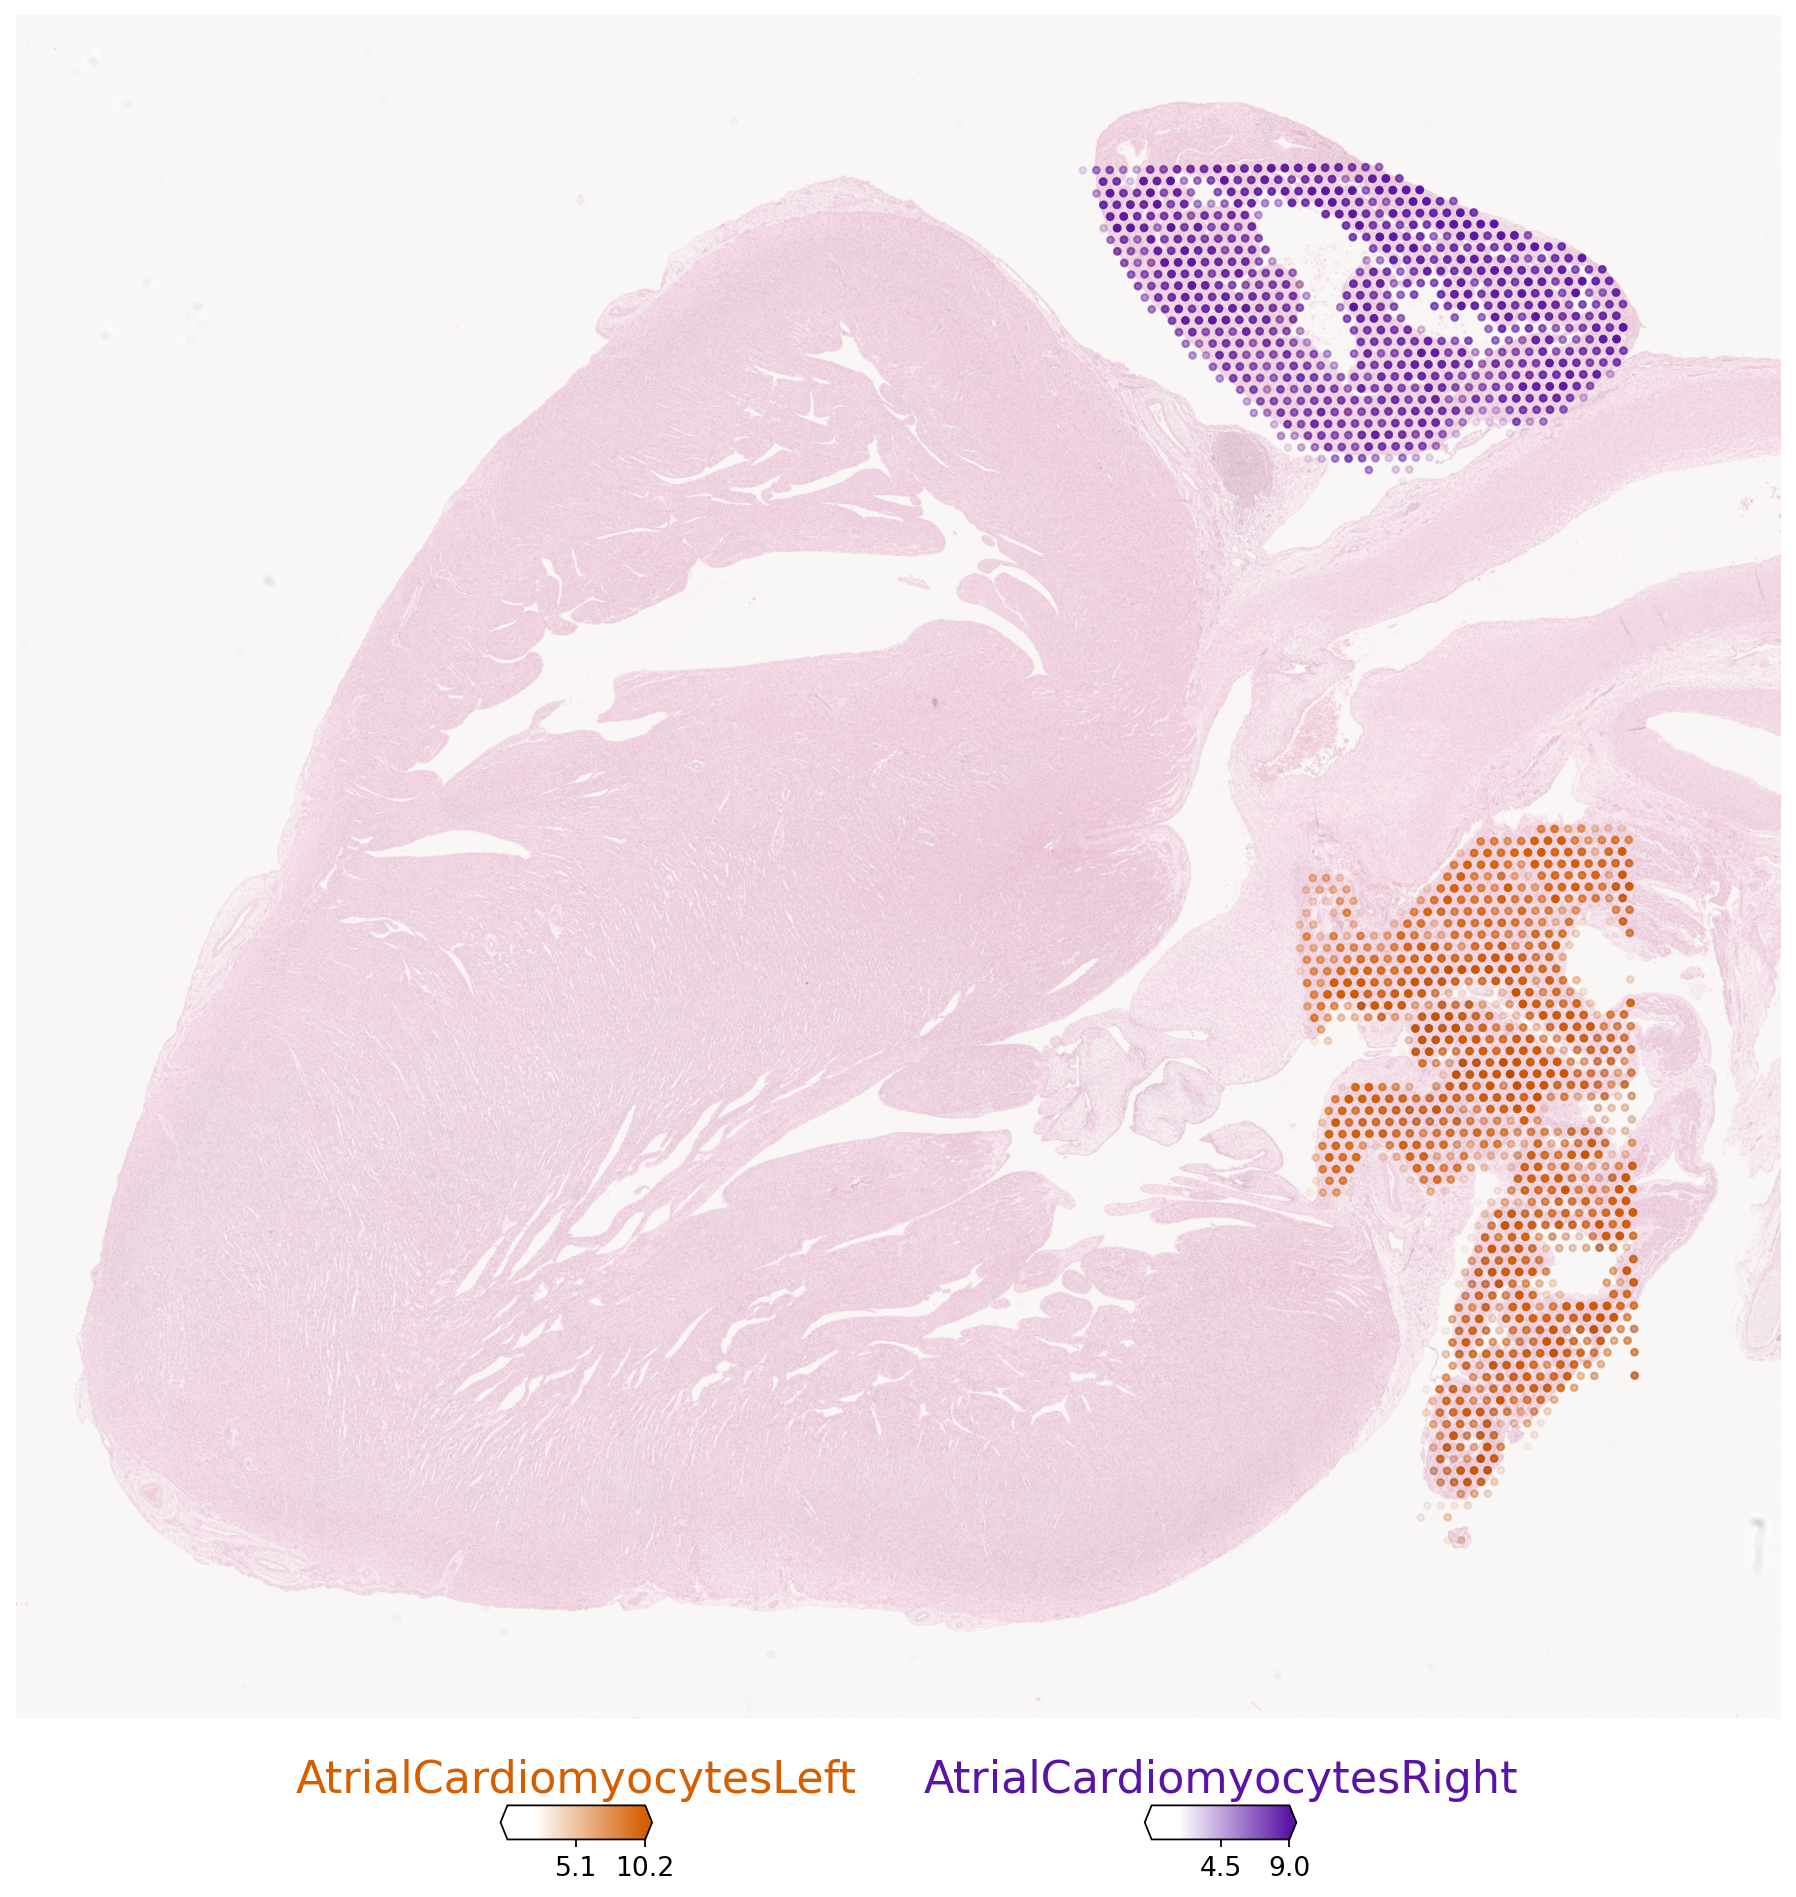

In [8]:
# select up to 6 clusters
# https://github.com/BayraktarLab/cell2location/blob/bd2aae833f81d8ab68684aa44f863b36e3af0aed/cell2location/plt/plot_spatial.py#L108

slide_id = 'BHF_F_Hea13295830'

slide = select_multislide(adata_vis, [slide_id])

clust_labels = ['AtrialCardiomyocytesLeft',
                'AtrialCardiomyocytesRight'
                ]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

plt.rcParams['axes.grid'] = False
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True, img_alpha=0.5,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.997,
        # size of locations (adjust depending on figure size)
        circle_diameter=3,
        colorbar_position='bottom',
        colorbar_shape = {'vertical_gaps': 0.1, 'horizontal_gaps': 5,
                                    'width': 1, 'height': 0.02},
        # crop_x=(650,820),
        # crop_y=(1200,1420),
        reorder_cmap = [1,4] # 'yellow' 'orange' 'blue' 'green' 'purple' 'grey' 'white'
    )
    plt.savefig(f"{figdir}/visium_cell2loc_LRaCMs_{slide_id}.pdf", bbox_inches="tight",dpi=300)

In [9]:
f"{figdir}/visium_cell2loc_LRaCMs_{slide_id}.pdf"

'/nfs/team205/heart/fetal_ms_figures/raw_plots/visium_cell2loc_LRaCMs_BHF_F_Hea13295830.pdf'